In [1]:
import pandas as pd
pd.options.display.max_columns = 100

In [2]:
muts_df = pd.read_pickle("./data/GYD_df.pkl")
muts_df.shape

(148, 45)

In [3]:
cond_cnt_d = {"none": 0}
feat_cnt = 0
for _, mut in muts_df.iterrows():
    for feat in mut["regulators"]:
        feat_cnt += 1
        if len(feat["significantly associated conditions"]) > 0:
            for cond in feat["significantly associated conditions"]:
                if cond in cond_cnt_d.keys():                   
                    cond_cnt_d[cond] += 1
                else:
                    cond_cnt_d[cond] = 1
        else:
            cond_cnt_d["none"] += 1

cond_cnt_d

{'none': 60, 'glycerol(2.5)': 214, 'NaCl(0.5g/L) trace elements': 128}

,condition,mutated feature count,proportion
0,none,60.0,0.194175
1,glycerol(2.5),214.0,0.692557
2,NaCl(0.5g/L) trace elements,128.0,0.414239


Text(0.5, 0, 'mutated feature count')

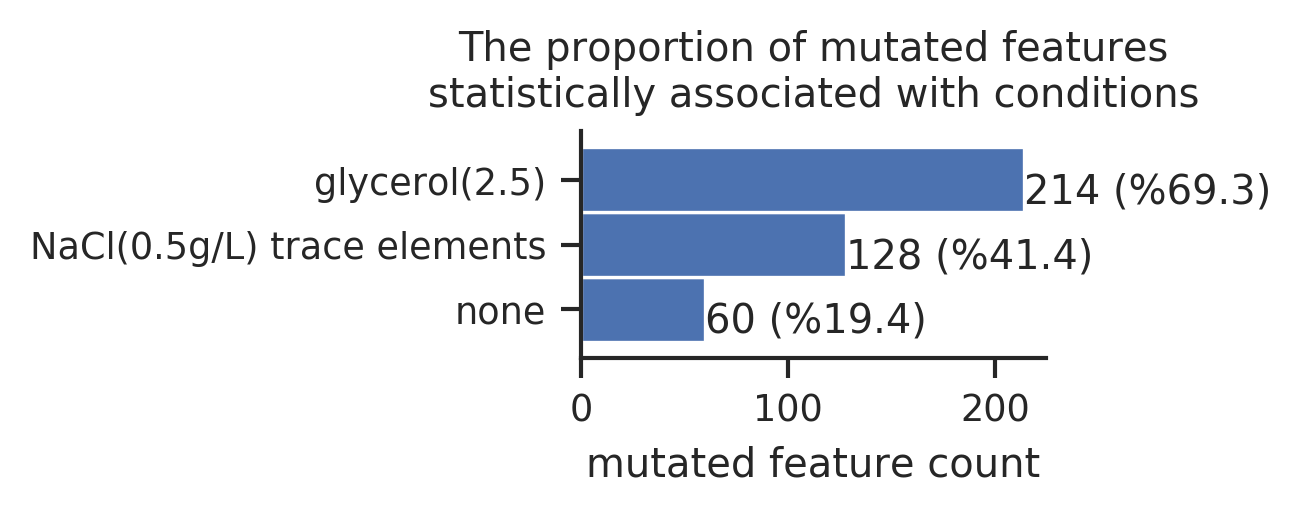

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("ticks")

cond_cnt_df = pd.DataFrame()
for key, val in cond_cnt_d.items():
    cond_cnt_df = cond_cnt_df.append({"condition": key, "mutated feature count": val, "proportion":val/feat_cnt}, ignore_index=True)
display(cond_cnt_df)

cond_cnt_df = cond_cnt_df.sort_values(by="mutated feature count", ascending=True)

ax = cond_cnt_df.plot.barh(
    y="mutated feature count",
    x="condition",
    color="#4C72B0",
    figsize=(2,1),
    width=1
)

cond_cnt_df = cond_cnt_df.reset_index()  # Resetting index for the below annotations to work
for i, r in cond_cnt_df.iterrows(): 
    s = str(int(r["mutated feature count"])) +' (%{0:.1f})'.format(r["proportion"] * 100)
    ax.text(r["mutated feature count"], i-0.35,  s)
sns.despine(ax=ax, top=True, right=True)
ax.set_title("The proportion of mutated features\nstatistically associated with conditions")
ax.get_legend().remove()
sns.despine(ax=ax, top=True, right=True)
ax.set_ylabel('')
ax.set_xlabel("mutated feature count")

In [5]:
import pickle
f = open("./data/signif_regulon_cond_json.pkl", 'rb')   
signif_genomic_feat_cond_json = pickle.load(f)
signif_genomic_feat_cond_json[0:5]

[{'mutated features': 'AcrR',
  'condition': 'glucose(2)',
  'odd ratio': 1.5194518176175962,
  'p value': 1.4348046136696324e-06},
 {'mutated features': 'AcrR',
  'condition': 'hexanoic acid',
  'odd ratio': 2.0000437225367818,
  'p value': 0.0063916141580635955},
 {'mutated features': 'AdiY',
  'condition': 'D-2-deoxyribose',
  'odd ratio': 10.04478092783505,
  'p value': 2.6702387715678554e-12},
 {'mutated features': 'AdiY',
  'condition': 'NaCl(0.5g/L) trace elements',
  'odd ratio': 2.5288788221970555,
  'p value': 0.00025128261701033933},
 {'mutated features': 'AraC',
  'condition': 'D-2-deoxyribose',
  'odd ratio': 4.377525252525253,
  'p value': 0.0032430737273837556}]

In [6]:
def get_signif_mut_conds(feat_name):
    signif_mut_conds = []
    for signif_mut_cond in signif_genomic_feat_cond_json:
        if signif_mut_cond['mutated features'] == feat_name:
            signif_mut_conds.append(signif_mut_cond)
    return signif_mut_conds
    
    

cond_mut_feat_assoc_df = pd.DataFrame()
for _, mut in muts_df.iterrows():
    for feat in mut["regulators"]:
        signif_mut_conds = get_signif_mut_conds(feat["name"])
        for d in signif_mut_conds:
            cond_mut_feat_assoc_df = cond_mut_feat_assoc_df.append(d, ignore_index=True)

cond_mut_feat_assoc_df.head()

,condition,mutated features,odd ratio,p value
0,glucose(4) or glycerol(2.5),CRP,6.678667,4.016158e-04
1,glycerol(2.5),CRP,3.066811,1.947311e-13
2,glucose(4) or glycerol(2.5),CRP,6.678667,4.016158e-04
3,glycerol(2.5),CRP,3.066811,1.947311e-13
4,NaCl(0.5g/L) trace elements,GlpR,2.537002,2.768793e-06


In [7]:
gyd_cond_mut_feat_assoc_df = cond_mut_feat_assoc_df[cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())].copy()

cross_counts_df = pd.crosstab(
    gyd_cond_mut_feat_assoc_df["mutated features"],
    gyd_cond_mut_feat_assoc_df["condition"]
)

cross_counts_df

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
CRP,0,106
CpxR,1,0
Cra,24,24
CspA,6,6
FNR,4,0
Fis,14,0
GadX,6,0
GlpR,30,30
LeuO,0,4


In [8]:
bin_df = cross_counts_df.copy()
for ir, r in bin_df.iterrows():
    for ic, c in r.items():
        if bin_df.loc[ir, ic] > 0:
            bin_df.loc[ir, ic] = 1
display(bin_df)

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
CRP,0,1
CpxR,1,0
Cra,1,1
CspA,1,1
FNR,1,0
Fis,1,0
GadX,1,0
GlpR,1,1
LeuO,0,1


In [9]:
# only want to plot genomic targets that have significant convergences
# I only want to look at mutated targets that have significant convergence
signif_gen_targ_s = set()
for _, r in muts_df.iterrows():
    for f in r["regulators"]:
        if f["significantly enriched"]:
            signif_gen_targ_s.add(f["name"])
signif_gen_targ_s

{'CRP', 'CspA', 'GlpR', 'Mlc', 'NagC'}

In [10]:
odds_df = bin_df.copy()
for feat, r in bin_df.iterrows():
    for cond, c in r.items():
        if bin_df.loc[feat, cond] > 0:
            odd_ratio = 0
            df = cond_mut_feat_assoc_df[
                (cond_mut_feat_assoc_df["condition"] == cond)
                & (cond_mut_feat_assoc_df["mutated features"] == feat)]["odd ratio"]
            if len(df):
                odd_ratio = df.unique()
            odds_df.loc[feat, cond] = odd_ratio

odds_df = odds_df[odds_df.index.isin(signif_gen_targ_s)]
# odds_df.index = '*'+odds_df.index
odds_df

condition,NaCl(0.5g/L) trace elements,glycerol(2.5)
mutated features,,
CRP,0.000000,3.066811
CspA,1.917600,6.190711
GlpR,2.537002,30.877297
Mlc,0.000000,9.024254
NagC,1.490787,3.490577


In [11]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.metadata_categories_for_associations import METADATA_CATEGORIES_FOR_ASSOCIATIONS

exp_conds_df = muts_df[METADATA_CATEGORIES_FOR_ASSOCIATIONS].drop_duplicates()
exp_conds_df

,temperature,carbon-source,supplement,strain-description,taxonomy-id,base-media,nitrogen-source,phosphorous-source,sulfur-source,calcium-source
630,37 celsius,glycerol(2.5),NaCl(0.5g/L) trace elements,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)


In [12]:
for i in exp_conds_df.columns:
    c = exp_conds_df.at[exp_conds_df.index[0], i]
    if c not in odds_df.columns:
        odds_df[c] = 0

odds_df

condition,NaCl(0.5g/L) trace elements,glycerol(2.5),37 celsius,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
mutated features,,,,,,,,,,
CRP,0.000000,3.066811,0,0,0,0,0,0,0,0
CspA,1.917600,6.190711,0,0,0,0,0,0,0,0
GlpR,2.537002,30.877297,0,0,0,0,0,0,0,0
Mlc,0.000000,9.024254,0,0,0,0,0,0,0,0
NagC,1.490787,3.490577,0,0,0,0,0,0,0,0


In [13]:
odds_df.to_pickle("./data/GYD_key_reg_assoc_odds.pkl")

Text(0.5, 94.91666666666656, '')

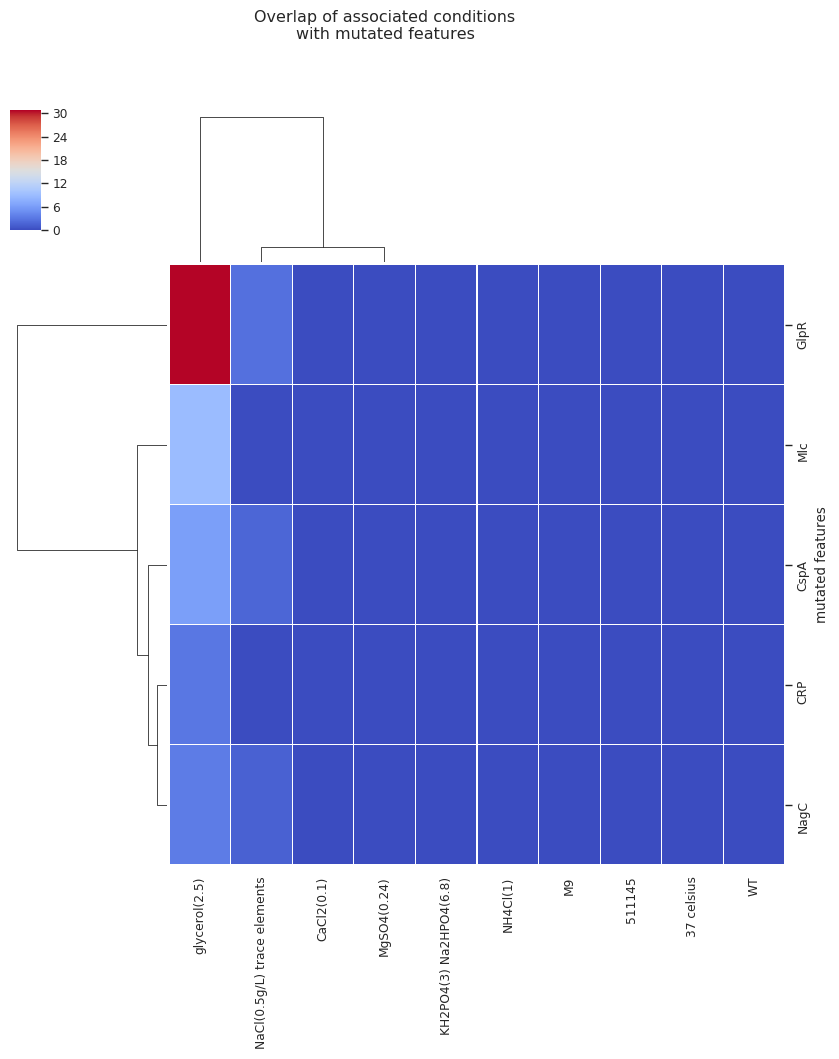

In [14]:
plt.rcParams["figure.dpi"] = 100
sns.set_context("paper")
sns.set_style("whitegrid")

from matplotlib.colors import LinearSegmentedColormap
myColors = ('#FFFFFF', "#4C72B0")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

g = sns.clustermap(
    odds_df,
    linewidths=0.1,
    cmap="coolwarm",
#     cmap=cmap,
#     xticklabels=False,
#     yticklabels=False,
#     figsize=(2,4.5)
)

# Fix for recent matplotlib/seaborn issue
g.ax_heatmap.set_ylim(len(odds_df)+0, -0)

# g.cax.set_visible(False)
# g.cax.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
ax = g.ax_heatmap
g.fig.suptitle("Overlap of associated conditions\nwith mutated features") 
# g.ax_heatmap.set_title(
#     "Overlap of associated conditions\nwith mutated features",
# #     loc='top'
# )
# ax.yaxis.set_ticks_position('left')
# ax.yaxis.set_label_position("left")
ax.set_xlabel('')

The clustermap generation code in the below cell won't execute if there is only one conditions being statistically associated to mutated features

In [15]:
# plt.rcParams["figure.dpi"] = 300
# sns.set_context("paper")
# sns.set_style("whitegrid")

# from matplotlib.colors import LinearSegmentedColormap
# myColors = ('#FFFFFF', "#4C72B0")
# cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# g = sns.clustermap(
#     bin_df,
#     linewidths=0.1,
#     cmap=cmap,
# #     xticklabels=False,
# #     yticklabels=False,
#     figsize=(2,4.5)
# )
# g.cax.set_visible(False)
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
# ax = g.ax_heatmap
# g.ax_heatmap.set_title(
#     "Overlap of associated conditions\nwith mutated features",
#     loc='left'
# )
# # ax.yaxis.set_ticks_position('left')
# ax.yaxis.set_label_position("left")
# ax.set_xlabel('')
# # plt.title()

In [16]:
key_mut_feat_df = cond_mut_feat_assoc_df[
    cond_mut_feat_assoc_df["condition"].isin(cond_cnt_d.keys())
]
key_mut_feat_df = key_mut_feat_df.drop_duplicates()
key_mut_feat_df

,condition,mutated features,odd ratio,p value
1,glycerol(2.5),CRP,3.066811,1.947311e-13
4,NaCl(0.5g/L) trace elements,GlpR,2.537002,2.768793e-06
6,glycerol(2.5),GlpR,30.877297,1.946116e-34
7,NaCl(0.5g/L) trace elements,PhoP,1.701997,4.477539e-03
10,NaCl(0.5g/L) trace elements,Fis,1.563412,2.118410e-05
15,NaCl(0.5g/L) trace elements,CspA,1.917600,5.721520e-03
18,glycerol(2.5),CspA,6.190711,5.730045e-04
20,NaCl(0.5g/L) trace elements,GadX,2.066380,3.363187e-06
26,NaCl(0.5g/L) trace elements,Cra,1.805293,6.449641e-08
30,glycerol(2.5),Cra,2.476350,3.645369e-03


In [17]:
# I only want to look at mutated targets that have significant convergence
# TODO: I've done this above with the odds_df as well. Shoud refactor both of these implementations together.
signif_reg_s = set()
for _, r in muts_df.iterrows():
    for reg in r["regulators"]:
        if reg["significantly enriched"]:
            signif_reg_s.add(reg["name"])

key_mut_feat_df = key_mut_feat_df[key_mut_feat_df["mutated features"].isin(signif_reg_s)]
key_mut_feat_df

,condition,mutated features,odd ratio,p value
1,glycerol(2.5),CRP,3.066811,1.947311e-13
4,NaCl(0.5g/L) trace elements,GlpR,2.537002,2.768793e-06
6,glycerol(2.5),GlpR,30.877297,1.946116e-34
15,NaCl(0.5g/L) trace elements,CspA,1.917600,5.721520e-03
18,glycerol(2.5),CspA,6.190711,5.730045e-04
33,glycerol(2.5),Mlc,9.024254,1.069741e-07
40,NaCl(0.5g/L) trace elements,NagC,1.490787,4.509835e-03
42,glycerol(2.5),NagC,3.490577,5.346399e-04


In [18]:
gly_key_mut_feat_df = key_mut_feat_df[key_mut_feat_df.condition=="glycerol(2.5)"]
gly_key_mut_feat_df

,condition,mutated features,odd ratio,p value
1,glycerol(2.5),CRP,3.066811,1.947311e-13
6,glycerol(2.5),GlpR,30.877297,1.946116e-34
18,glycerol(2.5),CspA,6.190711,5.730045e-04
33,glycerol(2.5),Mlc,9.024254,1.069741e-07
42,glycerol(2.5),NagC,3.490577,5.346399e-04


In [19]:
# for some reason I have to do this up here and not in the below plotting cell.
gly_key_mut_feat_df = gly_key_mut_feat_df.sort_values("odd ratio")
gly_key_mut_feat_df

,condition,mutated features,odd ratio,p value
1,glycerol(2.5),CRP,3.066811,1.947311e-13
42,glycerol(2.5),NagC,3.490577,5.346399e-04
18,glycerol(2.5),CspA,6.190711,5.730045e-04
33,glycerol(2.5),Mlc,9.024254,1.069741e-07
6,glycerol(2.5),GlpR,30.877297,1.946116e-34


In [20]:
# # Actually, I don't want to demonstrate the significance on the regulon labels here
# want to indicate that they're significant
# gly_key_mut_feat_df["mutated features"] = '*'+gly_key_mut_feat_df["mutated features"]
# gly_key_mut_feat_df

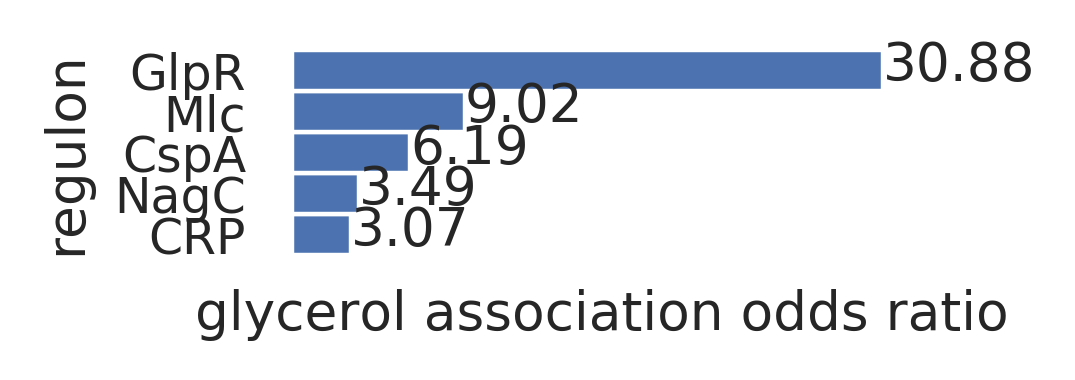

In [21]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 400
sns.set_context("paper")
sns.set_style("white")


ax = gly_key_mut_feat_df.plot.barh(
    y="odd ratio",
    x="mutated features",
    color="#4C72B0",
#     figsize=(3,0.75),  # CfB annual seminar talk
    figsize=(2,0.75),
    width=1
)

gly_key_mut_feat_df = gly_key_mut_feat_df.reset_index()  # Resetting index for the below annotations to work
for i, r in gly_key_mut_feat_df.iterrows():
    s = str(round(r["odd ratio"], 2))
#     ax.text(r["odd ratio"], i-0.3,  s)    
#     s = ""
#     if r["p value"] < 0.01:
#         s += " (p<0.01 **)"
#     else:
#         s += " (p=" + '{0:.3f})'.format(r["p value"])
    ax.text(r["odd ratio"], i-0.25,  s)
    
sns.despine(ax=ax,
            top=True,
            right=True, 
            bottom=True,
            left=True
           )
# ax.set_title("Mutated features\nassociated with L-serine and\nΔsdaA ΔsdaB ΔtdcG ΔglyA")
# ax.set_title("Mutated features\nassociated with glycerol")
# ax.set_title("Key mutation features\nassociated with glycerol")
# ax.set_title("Association of growth on glycerol\nfor significantly mutated regulons")
# ax.set_title("Glycerol growth association for\nsignificantly mutated regulons")
ax.get_legend().remove()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
#     bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
# ax.set_ylabel('significantly\nmutated\nregulons', rotation=45, ha="right")
ax.set_ylabel('regulon')
# plt.ylabel('significantly\nmutated\nregulons',rotation=0)
ax.set_xlabel("glycerol association odds ratio")
plt.savefig("fig.svg", format="svg")